In [1]:
import os
import glob
import pysam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
working_dir = '/vortexfs1/omics/env-bio/collaboration/dinoflagellates_METZYME/data/metaT_trimmed_reads/fasta_files/paired/mRNA/'

### Read in annotated ORF file with taxonomy

In [3]:
# Same TSV file generated in metaT_taxonomy.ipynb

dino_ORFs = 'dino_metzyme_annotated_coassembly_diamond_out_dinophyta.tsv'

df_dino = pd.read_csv(working_dir+dino_ORFs, sep='\t', header=0, index_col=0)

In [4]:
df_dino

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,Domain,Kingdom,Phylum,Class,Order,Family,Genus,Strain_name
227,NODE_26_length_11492_cov_18.457578_g19_i0_2_57...,Karenia-brevis-SP1-20130916|289615_1,33.7,1063,639,24,628,1654,3,1035,1.010000e-146,491.0,Eukaryota,Alveolata,Dinophyta,Dinophyceae,Dinophyceae_X,Dinophyceae_XX,Karenia,Karenia brevis SP1
231,NODE_14_length_13360_cov_26.370005_g9_i0_1698_...,Oxyrrhis-marina-20131105|151477_1,44.0,427,192,3,1,427,1,380,2.230000e-109,341.0,Eukaryota,Alveolata,Dinophyta,Dinophyceae,Dinophyceae_X,Oxyrrhinaceae,Oxyrrhis,Oxyrrhis marina
301,NODE_42_length_9922_cov_24.243123_g4_i1_2_1073_-,Karenia-brevis-SP1-20130916|45901_1,65.8,342,113,2,20,357,93,434,1.080000e-159,464.0,Eukaryota,Alveolata,Dinophyta,Dinophyceae,Dinophyceae_X,Dinophyceae_XX,Karenia,Karenia brevis SP1
442,NODE_55_length_9298_cov_13.604855_g19_i1_2_4708_-,Karenia-brevis-SP1-20130916|289615_1,33.7,1063,639,24,267,1293,3,1035,8.550000e-149,491.0,Eukaryota,Alveolata,Dinophyta,Dinophyceae,Dinophyceae_X,Dinophyceae_XX,Karenia,Karenia brevis SP1
449,NODE_55_length_9298_cov_13.604855_g19_i1_4759_...,Karenia-brevis-SP1-20130916|289615_1,33.7,1063,639,24,211,1237,3,1035,3.320000e-149,491.0,Eukaryota,Alveolata,Dinophyta,Dinophyceae,Dinophyceae_X,Dinophyceae_XX,Karenia,Karenia brevis SP1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720451,NODE_1961869_length_78_cov_2.724832_g1955307_i...,Kryptoperidinium-foliaceum-CCMP1326-20130916|1...,84.0,25,4,0,1,25,45,69,5.310000e-04,41.6,Eukaryota,Alveolata,Dinophyta,Dinophyceae,Dinophyceae_X,Dinophyceae_XX,Kryptoperidinium,Kryptoperidinium foliaceum CCMP1326
720455,NODE_1962240_length_74_cov_2.055172_g1955678_i...,Ceratium-fusus-PA161109-20140214|182283_1,90.9,22,2,0,1,22,7,28,3.300000e-05,42.7,Eukaryota,Alveolata,Dinophyta,Dinophyceae,Dinophyceae_X,Dinophyceae_XX,Ceratium,"Ceratium fusus, Strain PA161109"
720458,NODE_1962484_length_71_cov_2.323944_g1955922_i...,Durinskia-baltica-CSIRO_CS-38-20140214|100697_1,69.6,23,7,0,1,23,129,151,8.050000e-05,43.9,Eukaryota,Alveolata,Dinophyta,Dinophyceae,Dinophyceae_X,Dinophyceae_XX,Durinskia,"Durinskia baltica, Strain CSIRO CS-38"
720460,NODE_1962392_length_72_cov_2.405594_g1955830_i...,Karlodinium-micrum-CCMP2283-20140214|26356_1,77.3,22,5,0,2,23,81,102,4.360000e-04,40.8,Eukaryota,Alveolata,Dinophyta,Dinophyceae,Dinophyceae_X,Dinophyceae_XX,Karlodinium,"Karlodinium micrum, Strain CCMP2283"


### Read in output of BWA mem (mapping reads to ORFs)

In [5]:
#Start with a test example on just the sample at 40m depth

sam_path = 'bwa_mem_nucleotide_files/30B8Z_S11_001_40m_mRNA_mapped_sorted.bam'

#Use pysam to open the .bam file
samfile = pysam.AlignmentFile(working_dir+sam_path, "rb")

In [6]:
#index statistics -- gives us the number of reads mapped to each contig
idx_stats = samfile.get_index_statistics()
print(idx_stats[0])

IndexStats(contig='NODE_1_length_22561_cov_36.839973_g0_i0_72_1721_-', mapped=6, unmapped=0, total=6)


In [7]:
contigs = []
mapped = []
unmapped = []

#"Unravel" list of index stats into individual lists of contig name, number of mapped and unmapped reads
for contig_stat in idx_stats:
    contigs.append(contig_stat.contig)
    mapped.append(contig_stat.mapped)
    unmapped.append(contig_stat.unmapped)

In [8]:
#Generate a dataframe from the index statistics
ORF_read_counts = pd.DataFrame({'contig': contigs, 'mapped': mapped, 'unmapped': unmapped})

#Ignore all contigs with no mapping hits
ORF_read_counts = ORF_read_counts[ORF_read_counts['mapped'] != 0]

In [9]:
# Join just dinoflagellates ORFs with all ORFs wth a read count of at least 1
dino_ORF_reads = ORF_read_counts.join(df_dino.set_index('qseqid'), on='contig', how='inner')

#Get reference length from BAM file
dino_ORF_reads['reference_length'] = dino_ORF_reads['contig'].map(lambda x: samfile.get_reference_length(x))

### TPM calculation

Defined as $TPM = \frac{x_i}{l_i} \times \frac{1}{\sum\limits_{n}{\frac{x_n}{l_n}}} \times 10^6$

First, we want to sum over all of the read counts normalized by contig length. Assigning that to `sum_x_over_l`, we can then multiply it by each read count normalized by contig length to get the transcripts per million used by Cohen et al. 

In [10]:
sum_x_over_l = pd.DataFrame(dino_ORF_reads['mapped']/dino_ORF_reads['reference_length']).sum(axis=0).values[0]

In [11]:
dino_ORF_reads['TPM'] = dino_ORF_reads['mapped']/dino_ORF_reads['reference_length']*(1/sum_x_over_l)*10**6

In [12]:
dino_ORF_reads[['contig', 'sseqid', 'TPM']]

,contig,sseqid,TPM
241,NODE_26_length_11492_cov_18.457578_g19_i0_2_57...,Karenia-brevis-SP1-20130916|289615_1,19.788548
321,NODE_42_length_9922_cov_24.243123_g4_i1_2_1073_-,Karenia-brevis-SP1-20130916|45901_1,3.176910
470,NODE_55_length_9298_cov_13.604855_g19_i1_2_4708_-,Karenia-brevis-SP1-20130916|289615_1,8.630657
478,NODE_55_length_9298_cov_13.604855_g19_i1_4759_...,Karenia-brevis-SP1-20130916|289615_1,9.861188
490,NODE_51_length_9419_cov_15.559050_g34_i1_107_9...,Karenia-brevis-CCMP2229-20130916|270247_1,39.002140
...,...,...,...
2161693,NODE_1961248_length_86_cov_2.006369_g1954686_i...,MMETSP0796-20121207|30551_1,9.009648
2161878,NODE_1961696_length_80_cov_2.476821_g1955134_i...,MMETSP0784-20121206|7079_1,15.593622
2162074,NODE_1962484_length_71_cov_2.323944_g1955922_i...,Durinskia-baltica-CSIRO_CS-38-20140214|100697_1,7.051029
2162099,NODE_1962392_length_72_cov_2.405594_g1955830_i...,Karlodinium-micrum-CCMP2283-20140214|26356_1,7.051029


In [13]:
dino_ORF_reads.sort_values(by='TPM', ascending=False)

,contig,mapped,unmapped,sseqid,pident,length,mismatch,gapopen,qstart,qend,...,Domain,Kingdom,Phylum,Class,Order,Family,Genus,Strain_name,reference_length,TPM
222031,NODE_143768_length_655_cov_670.049658_g137723_...,1789,0,at05685-at,57.7,201,85,0,2,202,...,Eukaryota,Alveolata,Dinophyta,Dinophyceae,Dinophyceae_X,Dinophyceae_XX,Alexandrium,Alexandrium temarense CCMP1771,609,714.602683
32401,NODE_14066_length_1337_cov_805.969984_g4441_i3...,483,0,Symbiodinium-sp-CCMP2430-20130923|104772_1,100.0,55,0,0,1,55,...,Eukaryota,Alveolata,Dinophyta,Dinophyceae,Dinophyceae_X,Suessiales,Symbiodinium,Symbiodinium sp CCMP2430,165,712.089827
140229,NODE_82534_length_781_cov_367.628169_g77357_i0...,1122,0,Symbiodinium-sp-C1-20140214|25803_1,91.8,257,21,0,1,257,...,Eukaryota,Alveolata,Dinophyta,Dinophyceae,Dinophyceae_X,Suessiales,Symbiodinium,"Symbiodinium, Strain C1",774,352.633438
233168,NODE_152913_length_642_cov_711.809107_g146803_...,925,0,Symbiodinium-sp-C1-20140214|25803_1,93.0,213,15,0,1,213,...,Eukaryota,Alveolata,Dinophyta,Dinophyceae,Dinophyceae_X,Suessiales,Symbiodinium,"Symbiodinium, Strain C1",639,352.137656
1186533,NODE_996022_length_311_cov_541.416667_g989460_...,394,0,at05419-at,93.2,103,7,0,1,103,...,Eukaryota,Alveolata,Dinophyta,Dinophyceae,Dinophyceae_X,Dinophyceae_XX,Alexandrium,Alexandrium temarense CCMP1771,309,310.176818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14230,NODE_5127_length_1882_cov_4.823302_g4211_i0_48...,1,0,Symbiodinium-sp-C15-20130923|7961_1,90.1,609,60,0,3,611,...,Eukaryota,Alveolata,Dinophyta,Dinophyceae,Dinophyceae_X,Suessiales,Symbiodinium,Symbiodinium sp C15,1833,0.132712
13629,NODE_4558_length_1969_cov_4.565332_g3730_i0_3_...,1,0,MMETSP0795-20121207|7901_1,71.6,570,161,1,1,570,...,Eukaryota,Alveolata,Dinophyta,Syndiniales,Dino-Group-II,Dino-Group-II-Clade-4,Amoebophrya,Amoebophrya sp.,1896,0.128302
1222,NODE_183_length_6100_cov_9.477691_g126_i0_1591...,2,0,MMETSP0253-20130528|72244_1,30.2,1587,980,42,4,1493,...,Eukaryota,Alveolata,Dinophyta,Dinophyceae,Dinophyceae_X,Noctilucales,Noctiluca,Noctiluca scintillans,4509,0.107900
1678,NODE_271_length_5332_cov_6.018628_g194_i0_103_...,1,0,MMETSP0795-20121207|5263_1,52.6,832,364,11,10,828,...,Eukaryota,Alveolata,Dinophyta,Syndiniales,Dino-Group-II,Dino-Group-II-Clade-4,Amoebophrya,Amoebophrya sp.,2487,0.097813


### Full script below to process each sample and merge into one dataframe

In [14]:
sam_paths = ['bwa_mem_nucleotide_files/30B8Z_S11_001_40m_mRNA_mapped_sorted.bam', 
             'bwa_mem_nucleotide_files/30B91_S28_001_380m_mRNA_mapped_sorted.bam',
            'bwa_mem_nucleotide_files/30B90_S12_001_70m_mRNA_mapped_sorted.bam']

In [15]:
i=0
for path in sam_paths:
    samfile = pysam.AlignmentFile(working_dir+path, "rb")
    sample_id = path.split('/')[1].split('_mRNA')[0]
    
    idx_stats = samfile.get_index_statistics()
    
    contigs = []
    mapped = []
    unmapped = []

    for contig_stat in idx_stats:
        contigs.append(contig_stat.contig)
        mapped.append(contig_stat.mapped)
        unmapped.append(contig_stat.unmapped)
        
    ORF_read_counts = pd.DataFrame({'contig': contigs, 'mapped': mapped, 'unmapped': unmapped})

    #Ignore all contigs with no mapping hits
    ORF_read_counts = ORF_read_counts[ORF_read_counts['mapped'] != 0]
    
    dino_ORF_reads = ORF_read_counts.join(df_dino.set_index('qseqid'), on='contig', how='inner')

    #Get reference length from BAM file
    dino_ORF_reads['reference_length'] = dino_ORF_reads['contig'].map(lambda x: samfile.get_reference_length(x))
    
    sum_x_over_l = pd.DataFrame(dino_ORF_reads['mapped']/dino_ORF_reads['reference_length']).sum(axis=0).values[0]
    
    dino_ORF_reads['TPM'] = dino_ORF_reads['mapped']/dino_ORF_reads['reference_length']*(1/sum_x_over_l)*10**6
    
    if i == 0:
        output_df = dino_ORF_reads[['contig', 'TPM']]
        output_df = output_df.rename({'TPM': 'TPM_'+ sample_id}, axis=1)
    else:
        output_df = output_df.join(dino_ORF_reads[['contig', 'TPM']].set_index('contig'), how='outer', on='contig')
    output_df = output_df.rename({'TPM': 'TPM_'+ sample_id}, axis=1)
    
    i+=1 

In [16]:
# Change NaNs to 0s for calculation
output_df[['TPM_30B8Z_S11_001_40m', 'TPM_30B91_S28_001_380m', 'TPM_30B90_S12_001_70m']] = output_df[['TPM_30B8Z_S11_001_40m', 'TPM_30B91_S28_001_380m', 'TPM_30B90_S12_001_70m']].fillna(0)

In [17]:
output_df.head()

,contig,TPM_30B8Z_S11_001_40m,TPM_30B91_S28_001_380m,TPM_30B90_S12_001_70m
241.0,NODE_26_length_11492_cov_18.457578_g19_i0_2_57...,19.788548,1.390007,1.850755
321.0,NODE_42_length_9922_cov_24.243123_g4_i1_2_1073_-,3.176910,9.333768,5.880087
470.0,NODE_55_length_9298_cov_13.604855_g19_i1_2_4708_-,8.630657,1.524978,1.707436
478.0,NODE_55_length_9298_cov_13.604855_g19_i1_4759_...,9.861188,0.910516,1.319295
490.0,NODE_51_length_9419_cov_15.559050_g34_i1_107_9...,39.002140,3.153441,3.198434


### Calculating z-scores

In [18]:
z_score_40m = (np.log2(output_df['TPM_30B8Z_S11_001_40m'] + 1) 
               - np.mean(output_df['TPM_30B8Z_S11_001_40m']))/(np.std(output_df['TPM_30B8Z_S11_001_40m']))

In [19]:
log2_40 = np.log2(output_df['TPM_30B8Z_S11_001_40m'] + 1).values
df_40 = output_df['TPM_30B8Z_S11_001_40m'].values
log2_380 = np.log2(output_df['TPM_30B91_S28_001_380m'] + 1).values
df_380 = output_df['TPM_30B91_S28_001_380m'].values
log2_70 = np.log2(output_df['TPM_30B90_S12_001_70m'] + 1).values
df_70 = output_df['TPM_30B90_S12_001_70m'].values

n = log2_380.shape[0]

In [20]:
test1 = np.concatenate([((log2_40 - np.mean(df_40))/np.std(df_40)).reshape((n, 1)),
                       ((log2_70 - np.mean(df_70))/np.std(df_70)).reshape((n, 1)), 
                       ((log2_380 - np.mean(df_380))/np.std(df_380)).reshape((n, 1))], axis=1)


(0.0, 100.0)

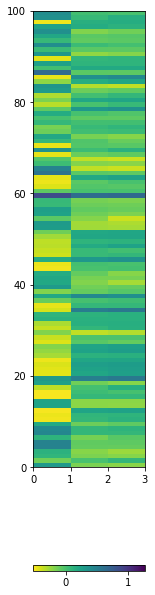

In [21]:
plt.figure(figsize = (2, 12))
plt.pcolormesh(test1, cmap='viridis_r')
plt.colorbar(orientation='horizontal')
plt.ylim([0, 100])

### Bringing in the KEGG annotation data for making Figure 3

In [88]:
kegg_file = '/vortexfs1/omics/env-bio/collaboration/dinoflagellates_METZYME/data/metaT_trimmed_reads/fasta_files/paired/mRNA/KEGG_annotation/' \
            'dino_metzyme_annotated_coassembly_KEGG_annotation.txt'

In [89]:
top_50_genes = '/vortexfs1/omics/env-bio/collaboration/dinoflagellates_METZYME/data/metaT_trimmed_reads/fasta_files/paired/mRNA/KEGG_annotation/' \
            'top_50_kegg_genes.txt'
file = open(top_50_genes, 'r')
top_KOs = file.read().splitlines()

In [90]:
columns = ['Query', 'KO']
kegg_df = pd.read_csv(kegg_file, sep='\t', names=columns)

### Need to incorporate KOG and Pfam annotations

In [25]:
hmmer_dir = '/vortexfs1/omics/env-bio/collaboration/dinoflagellates_METZYME/data/metaT_trimmed_reads/fasta_files/paired/mRNA/hmmer_output/'
kog_file = hmmer_dir + 'dino_metzyme_annotated_coassembly_KOG2348_out'

In [26]:
ISIP2A_file = hmmer_dir + 'dino_metzyme_annotated_coassembly_low_iron_inducible_periplasmic_protein_out'
ISIP3_file = hmmer_dir + 'dino_metzyme_annotated_coassembly_iron_storage_protein_out'
PF01036_file = hmmer_dir + 'dino_metzyme_annotated_coassembly_proteorhodopsin_out'

In [27]:
# These should be the same for all hmmer output -- first rows are just metadata, 
# and then skipping the row that just has dashes to separate the header from the data

skip_rows_list = [i for i in range(14)]
skip_rows_list += [15]

#Requires some manual analysis to identify where the relevant rows end, because it depends on the e-value
#we chose and how many fall below that. Would be nice to automate this if possible

KOG_2348 = pd.read_csv(kog_file, sep='\s+', skiprows=skip_rows_list, nrows=248)

In [28]:
skip_rows_list = [i for i in range(13)]
skip_rows_list += [14]

ISIP2A = pd.read_csv(ISIP2A_file, sep='\s+', skiprows=skip_rows_list, nrows=343)

In [29]:
skip_rows_list = [i for i in range(13)]
skip_rows_list += [14]

ISIP3 = pd.read_csv(ISIP3_file, sep='\s+', skiprows=skip_rows_list, nrows=45)

In [219]:
isip3_df = ISIP3[['Sequence']]
isip3_df['function'] = 'ISIP_3'

/tmp/ipykernel_90569/1843089003.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isip3_df['function'] = 'ISIP_3'


In [30]:
skip_rows_list = [i for i in range(13)]
skip_rows_list += [14]

PF01036 = pd.read_csv(PF01036_file, sep='\s+', skiprows=skip_rows_list, nrows=1140)

In [67]:
kog_df = KOG_2348[['Sequence']]
kog_df['function'] = 'KOG2348'

proteorhodopsin_df = PF01036[['Sequence']]
proteorhodopsin_df['function'] = 'PF01036'

isip2a_df = ISIP2A[['Sequence']]
isip2a_df['function'] = 'pti:PHATRDRAFT_54465'

isip3_df = ISIP3[['Sequence']]
isip3_df['function'] = 'pti:PHATRDRAFT_47674'

added_function_df = pd.concat([kog_df, proteorhodopsin_df ,isip2a_df, isip3_df])

/tmp/ipykernel_392267/1520715355.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kog_df['function'] = 'KOG2348'
/tmp/ipykernel_392267/1520715355.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proteorhodopsin_df['function'] = 'PF01036'
/tmp/ipykernel_392267/1520715355.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [68]:
#Joining both taxonomy and functional annotation in the same dataframe

tax_func_df = output_df.join(kegg_df.set_index('Query'), on='contig', how='left')
tax_func_df = tax_func_df.join(added_function_df.set_index('Sequence'), on='contig', how='left')

tax_func_df = tax_func_df.reset_index(drop=True)


In [69]:
ko_summed = tax_func_df[tax_func_df['KO'].isin(top_KOs)].groupby('KO').sum()
ko_summed.reset_index(inplace=True)
ko_summed = ko_summed.rename({'KO': 'functional_annotation'}, axis=1)

In [138]:
other_func_summed = tax_func_df[~tax_func_df['function'].isnull()].groupby('function').sum()
other_func_summed.reset_index(inplace=True)
other_func_summed = other_func_summed.rename({'function': 'functional_annotation'}, axis=1)

In [156]:
top_50_df = pd.concat([ko_summed, other_func_summed])
top_50_df = top_50_df.set_index('functional_annotation')

In [157]:
# Figure out if any genes in Cohen et al's top 50 list were not identified with KEGG, KOG or Pfam annotations
missing_KOs = np.array(top_KOs)[~np.array([KO in top_50_df.index for KO in top_KOs])]

missing_dict = {}
missing_dict['functional_assignment'] = missing_KOs
for col in top_50_df.columns:
    missing_dict[col] = np.repeat(np.nan, len(missing_KOs))
    
top_50_df = pd.concat([top_50_df, pd.DataFrame(missing_dict).set_index('functional_assignment')])

#Sort according to same list as in original paper
top_50_df = top_50_df.loc[top_KOs]

In [158]:
log2_40 = np.log2(top_50_df['TPM_30B8Z_S11_001_40m'] + 1).values
log2_380 = np.log2(top_50_df['TPM_30B91_S28_001_380m'] + 1).values
log2_70 = np.log2(top_50_df['TPM_30B90_S12_001_70m'] + 1).values

n = log2_380.shape[0]

In [161]:
top_50_df_log_norm

,TPM_30B8Z_S11_001_40m,TPM_30B91_S28_001_380m,TPM_30B90_S12_001_70m
K10808,9.713905,8.732109,8.721039
K00958,8.730985,7.035748,7.168721
K01923,9.180491,8.696354,8.589209
K00615,9.111709,8.641077,8.549922
K00031,9.547111,8.679623,8.763616
PF01036,13.400389,11.241197,11.221997
K00548,10.400468,9.384617,9.445462
K07004,0.000000,2.068226,1.000395
K01648,10.049270,9.400934,9.423663
K01735,4.134792,5.980891,5.684811


In [145]:
z_score_40 = (log2_40 - np.mean(log2_40))/(np.std(log2_40))
z_score_70 = (log2_70 - np.mean(log2_70))/(np.std(log2_70))
z_score_380 = (log2_380 - np.mean(log2_380))/(np.std(log2_380))

In [160]:
top_50_df_log_norm = top_50_df[['TPM_30B8Z_S11_001_40m', 'TPM_30B91_S28_001_380m', 'TPM_30B90_S12_001_70m']].apply(
    lambda x: np.log2(x + 1))

In [147]:
z_score_40 = (top_50_df_log_norm['TPM_30B8Z_S11_001_40m'] - top_50_df_log_norm.mean(axis=1))/(top_50_df_log_norm.std(axis=1))
z_score_70 = (top_50_df_log_norm['TPM_30B90_S12_001_70m'] - top_50_df_log_norm.mean(axis=1))/(top_50_df_log_norm.std(axis=1))
z_score_380 = (top_50_df_log_norm['TPM_30B91_S28_001_380m'] - top_50_df_log_norm.mean(axis=1))/(top_50_df_log_norm.std(axis=1))


In [165]:
test1 = np.concatenate([z_score_40.values.reshape(n, 1), z_score_70.values.reshape(n, 1), z_score_380.values.reshape(n, 1)], axis=1)

In [77]:
# test1 = np.concatenate([((np.log2(ko_summed['TPM_30B8Z_S11_001_40m'].values + 1) - 
#                          np.log2(ko_summed.mean(axis=1).values))/(np.log2(ko_summed.std(axis=1).values))).reshape((n, 1)),
#                        ((np.log2(ko_summed['TPM_30B90_S12_001_70m'].values + 1) - 
#                          np.log2(ko_summed.mean(axis=1).values))/(np.log2(ko_summed.std(axis=1).values))).reshape((n, 1)), 
#                        ((np.log2(ko_summed['TPM_30B91_S28_001_380m'].values + 1) - 
#                          np.log2(ko_summed.mean(axis=1).values))/(np.log2(ko_summed.std(axis=1).values))).reshape((n, 1))], axis=1)


In [167]:
labels = top_KOs

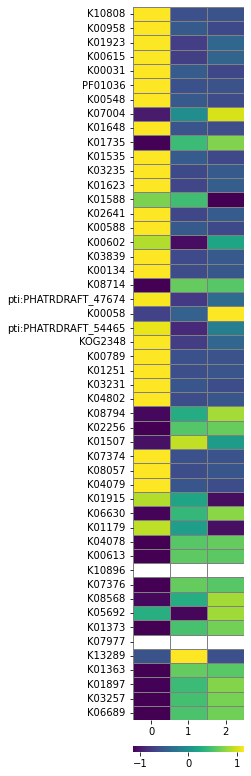

In [168]:
fig, ax = plt.subplots(figsize = (2, 16))
cb = sns.heatmap(test1, linecolor='gray', linewidth=0.5, cmap='viridis', yticklabels=labels, 
                 cbar_kws={"orientation": "horizontal", "pad": 0.03})
#ax.yaxis.set(ticks=np.arange(0.5, len(labels)), ticklabels=labels);